In [4]:



project_path = "/content/drive/MyDrive/Colab Notebooks"
data_raw_path = project_path + "/Data/heart_disease_ucirepo.csv"
cleaned_path = project_path + "/Data/heart_disease_cleaned.csv"
pca_path = project_path + "/Data/heart_disease_pca.csv"


In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv(data_raw_path)




# show basic info
df.head()
print("\nColumns and dtypes:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [6]:

target_col = df.columns[-1]
print("Target column:", target_col)
print(df[target_col].value_counts(dropna=False))


Target column: target
target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64


In [8]:
features = df.drop(columns=[target_col]).copy()
features = features.apply(lambda col: pd.to_numeric(col, errors='coerce'))


target = df[target_col]

print(features.isnull().sum())


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64


In [18]:


categorical_cols = ["cp", "fbs", "restecg", "exang", "slope", "thal", "ca"]
numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]

target = df["target"]


df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)


features = pd.concat([df[numeric_cols], df_encoded], axis=1)

print("Features shape:", features.shape)
print("Classes in target:", target.unique())



Features shape: (303, 12)
Classes in target: [0 2 1 3 4]


,age,trestbps,chol,thalach,oldpeak,cp,fbs,restecg,exang,slope,thal,ca
0,63,145,233,150,2.3,1,1,2,0,3,6.0,0.0
1,67,160,286,108,1.5,4,0,2,1,2,3.0,3.0
2,67,120,229,129,2.6,4,0,2,1,2,7.0,2.0
3,37,130,250,187,3.5,3,0,0,0,3,3.0,0.0
4,41,130,204,172,1.4,2,0,2,0,1,3.0,0.0


In [19]:
from sklearn.impute import SimpleImputer


num_imputer = SimpleImputer(strategy='median')


cat_imputer = SimpleImputer(strategy='most_frequent')


if numeric_cols:
    features[numeric_cols] = num_imputer.fit_transform(features[numeric_cols])
if categorical_cols:
    features[categorical_cols] = cat_imputer.fit_transform(features[categorical_cols])

#
if target.isnull().any():
    # if target missing, drop those rows — can't train without label
    print("Target has missing values — will drop those rows.")
    mask = target.notnull()
    features = features[mask]
    target = target[mask].astype(int)

print("\nMissing after imputation:\n", features.isnull().sum())
print("Shape after imputation:", features.shape)



Missing after imputation:
 age         0
trestbps    0
chol        0
thalach     0
oldpeak     0
cp          0
fbs         0
restecg     0
exang       0
slope       0
thal        0
ca          0
dtype: int64
Shape after imputation: (303, 12)


In [22]:
# One-hot encode categorical variables
features_encoded = pd.get_dummies(features, columns=categorical_cols, drop_first=True)
print("Shape after encoding:", features_encoded.shape)
features_encoded.head()



Shape after encoding: (303, 19)


,age,trestbps,chol,thalach,oldpeak,cp_2.0,cp_3.0,cp_4.0,fbs_1.0,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,thal_6.0,thal_7.0,ca_1.0,ca_2.0,ca_3.0
0,63.0,145.0,233.0,150.0,2.3,False,False,False,True,False,True,False,False,True,True,False,False,False,False
1,67.0,160.0,286.0,108.0,1.5,False,False,True,False,False,True,True,True,False,False,False,False,False,True
2,67.0,120.0,229.0,129.0,2.6,False,False,True,False,False,True,True,True,False,False,True,False,True,False
3,37.0,130.0,250.0,187.0,3.5,False,True,False,False,False,False,False,False,True,False,False,False,False,False
4,41.0,130.0,204.0,172.0,1.4,True,False,False,False,False,True,False,False,False,False,False,False,False,False


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_encoded)
X = pd.DataFrame(X_scaled, columns=features_encoded.columns)
print("Final features shape (ready for PCA):", X.shape)

print(features_encoded.columns.tolist())


Final features shape (ready for PCA): (303, 19)
['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'fbs_1.0', 'restecg_1.0', 'restecg_2.0', 'exang_1.0', 'slope_2.0', 'slope_3.0', 'thal_6.0', 'thal_7.0', 'ca_1.0', 'ca_2.0', 'ca_3.0']


In [24]:

cleaned_df = X.copy()
cleaned_df[target_col] = target.values
cleaned_df.to_csv(cleaned_path, index=False)
print("Saved cleaned dataset to:", cleaned_path)


Saved cleaned dataset to: /content/drive/MyDrive/Colab Notebooks/Data/heart_disease_cleaned.csv


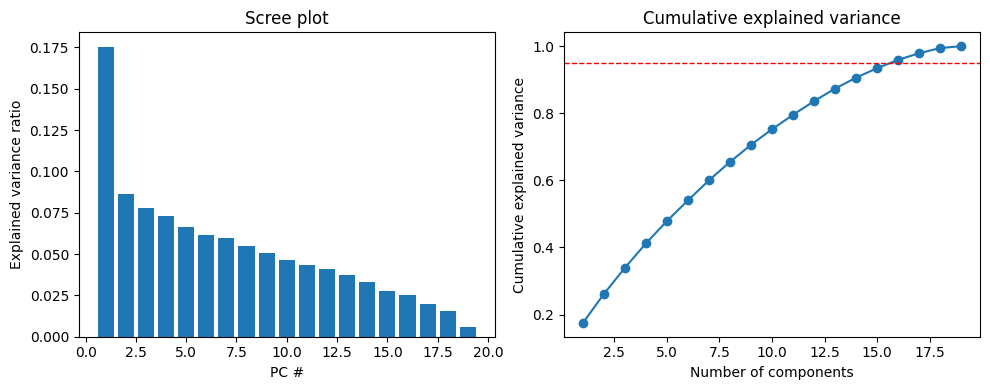

Components to retain 95% variance: 16
Shape with 90% variance: (303, 14)
Saved PCA data to: /content/drive/MyDrive/Colab Notebooks/Data/heart_disease_pca.csv


In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1) Fit PCA (no n_components) to inspect explained variance
pca = PCA()
pca.fit(X)
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# 2) Scree & cumulative plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(np.arange(1, len(explained)+1), explained)
plt.xlabel('PC #'); plt.ylabel('Explained variance ratio'); plt.title('Scree plot')

plt.subplot(1,2,2)
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker='o')
plt.xlabel('Number of components'); plt.ylabel('Cumulative explained variance')
plt.axhline(0.95, color='red', linestyle='--', linewidth=1)
plt.title('Cumulative explained variance')
plt.tight_layout()
plt.show()

# 3) Choose n_components that cover e.g. 95% variance
n_comp_95 = np.searchsorted(cum_explained, 0.95) + 1
print("Components to retain 95% variance:", n_comp_95)

# 4) Fit PCA with chosen number (alternatively use n_components=0.95 to auto)
pca_90 = PCA(n_components=0.90)
X_pca_90 = pca_90.fit_transform(X)
print("Shape with 90% variance:", X_pca_90.shape)

# Save PCA-transformed data
pd.DataFrame(X_pca_90).to_csv(pca_path, index=False)
print("Saved PCA data to:", pca_path)


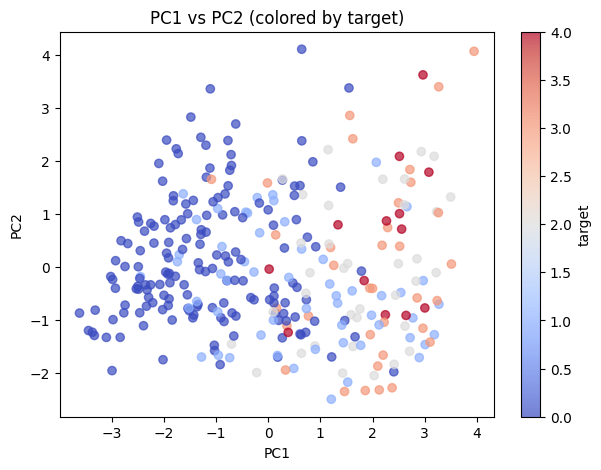

In [30]:
import matplotlib.pyplot as plt

# If we have at least 2 components:
if X_pca_90.shape[1] >= 2:
    plt.figure(figsize=(7,5))
    scatter = plt.scatter(X_pca_90[:,0], X_pca_90[:,1], c=target, cmap='coolwarm', alpha=0.7)
    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PC1 vs PC2 (colored by target)')
    # colorbar for binary labels is fine
    plt.colorbar(scatter, label=target_col)
    plt.show()
else:
    print("Less than 2 PCA components available — skipping 2D plot.")


In [33]:

components = pca_90.components_
feature_names = X.columns

if components.shape[0] >= 1:
    for i in range(min(2, components.shape[0])):
        comp = components[i]
        loading_df = pd.DataFrame({'feature': feature_names, 'loading': comp})
        loading_df['abs_loading'] = loading_df['loading'].abs()
        top = loading_df.sort_values('abs_loading', ascending=False).head(10)
        print(f"\nTop contributors to PC{i+1}:")
        display(top[['feature','loading']])



Top contributors to PC1:


,feature,loading
7,cp_4.0,0.392881
3,thalach,-0.374642
4,oldpeak,0.352717
11,exang_1.0,0.341024
12,slope_2.0,0.287422
15,thal_7.0,0.271078
0,age,0.259783
5,cp_2.0,-0.255502
6,cp_3.0,-0.219139
17,ca_2.0,0.167194



Top contributors to PC2:


,feature,loading
1,trestbps,0.418386
8,fbs_1.0,0.375607
13,slope_3.0,0.353399
6,cp_3.0,0.322398
7,cp_4.0,-0.279143
0,age,0.278731
18,ca_3.0,0.216356
11,exang_1.0,-0.214985
4,oldpeak,0.199585
16,ca_1.0,-0.182427
